# CITS5017 Project 1
Kaylee Molin (22734429)

September 2023

---

## Importing Relevant Packages

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
import time
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score

## Loading dataset

In [2]:
# Loading the CIFAR-10 dataset and ensuring its dimensions match expectations
(X_train_original, y_train_original), (X_test_original, y_test_original) = tf.keras.datasets.cifar10.load_data()

# Asserting that the loaded dataset has the correct dimensions
assert X_train_original.shape == (50000, 32, 32, 3)  # Training images should be 50,000 samples of 32x32 pixels in RGB.
assert X_test_original.shape == (10000, 32, 32, 3)   # Test images should be 10,000 samples of 32x32 pixels in RGB.
assert y_train_original.shape == (50000, 1)          # Training labels should have a shape of (50000, 1).
assert y_test_original.shape == (10000, 1)           # Test labels should have a shape of (10000, 1).

## Normalising the pixel values to be between 0 and 1
These models perform better when data is in this range.

In [3]:
# Normalising the pixel values of training and test data by scaling them to the range [0, 1].
X_train_norm, X_test = X_train_original/255.0, X_test_original/255.0
y_test=y_test_original
y_train = y_train_original

## Forming a validation set from the training set

To create a validation set, we are using an 85/15 ratio, dividing the current training data into a reduced training set and a separate validation set. The original testing set remains unchanged.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.15, random_state=22, stratify=y_train_original)

# Printing the shapes of the resulting datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (42500, 32, 32, 3)
y_train: (42500, 1)

Validation set shapes:
X_val: (7500, 32, 32, 3)
y_val: (7500, 1)

Test set shapes:
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


> The dimensions of each set are displayed above. The 'y' data contains the corresponding labels for each instance in the dataset. The classes are also perfectly balanced.

## Function to display 20 randomly sampled images

In [5]:
def display_random_subset(X, y, class_names, title):
    ''' Displays a random subset of images with their corresponding class labels.'''
    plt.figure(figsize=(12, 6))
    indices = np.random.randint(0, len(X), size=20)

    for i, index in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(X[index])
        plt.title(class_names[y[index][0]])
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()


In [6]:
# Load class names from TFDS
dataset_info = tfds.builder("cifar10")
class_names = dataset_info.info.features["label"].names

### Displaying 20 random images from the training set

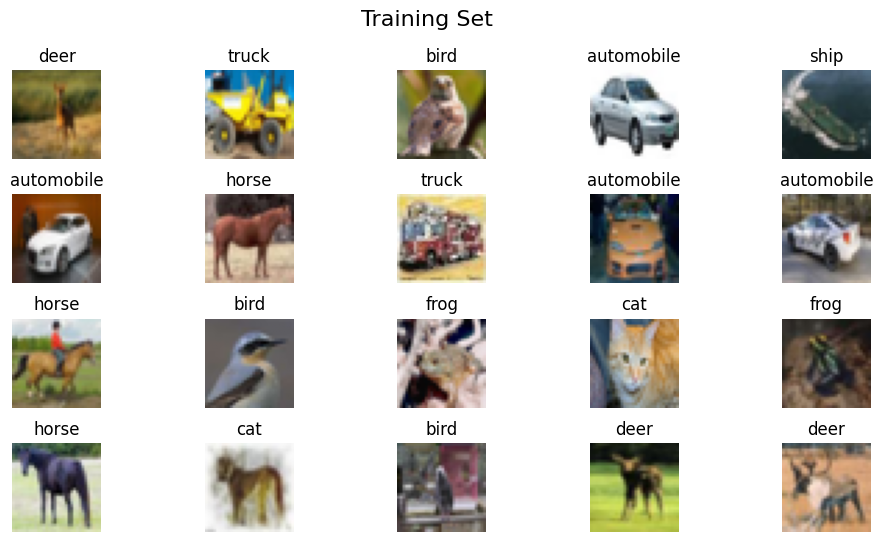

In [7]:
display_random_subset(X_train, y_train, class_names, "Training Set")

### Displaying 20 random images from the validation set

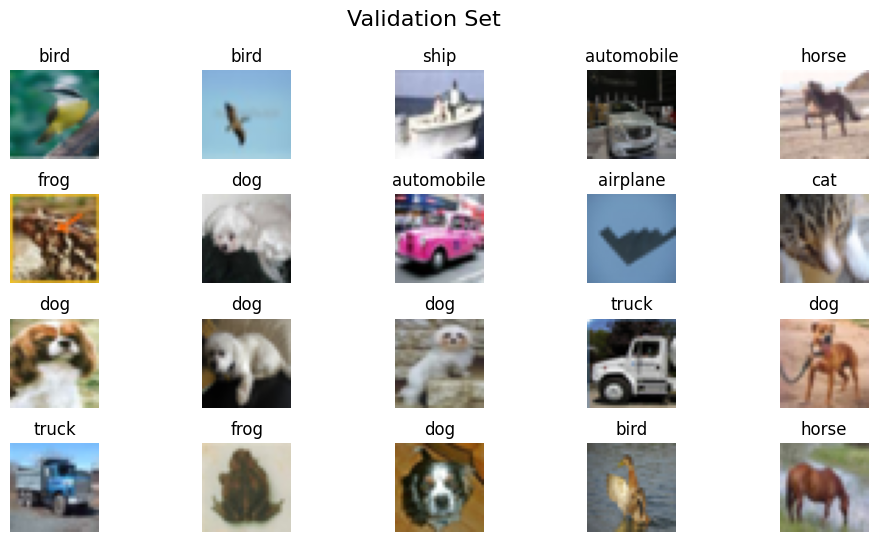

In [8]:
display_random_subset(X_val, y_val, class_names, "Validation Set")

### Displaying 20 random images from the testing set

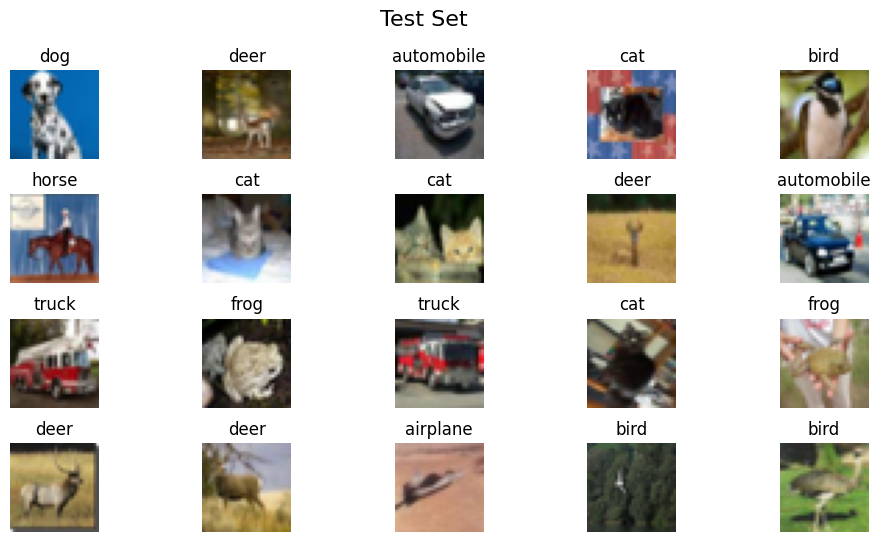

In [9]:
display_random_subset(X_test, y_test, class_names, "Test Set")

## Implementing an MLP

In [10]:
def create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0):
  ''' Creates an MLP for image classification. '''
  model = Sequential([
    Flatten(input_shape=[32, 32, 3]),
    Dense(512, activation='relu', kernel_initializer=weight_initializer),
    Dropout(dropout_rate),
    Dense(256, activation='relu', kernel_initializer=weight_initializer),
    Dropout(dropout_rate),
    Dense(10, activation='softmax')
  ])

  optimizer = SGD(learning_rate=learning_rate)

  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

> The above code defines the architecture of the MLP model. This MLP consists of an input layer, two hidden layers, and an output layer.

**Architecture**

>*Input layer*:
- The inputted images have dimensions (32, 32, 3). When flattened, the resulting array is 3072 long.

>*Hidden layers*:
- This model uses two hidden layers, one with 512 neurons and the other with 256 neurons and has been chosen purposefully. Firstly, it reduces model complexity, which can prevent overfitting to the training data. Secondly, it accelerates training as fewer parameters need tuning. This configuration of neurons in the hidden layers aligns with common choices in various neural network architectures.
- The input layer begins with 3072 neurons, and a gradual reduction in the number of neurons in each layer results in an efficient and effective model.
- I did also try using more neurons and 3 hidden layers, however, the increase in accuracy was minimal. Hence, I opted for a simpler model with comparable accuracy.
- I opted for the $ReLU$ activation function, which transforms inputs into values greater than or equal to zero. $ReLU$ is quick and effective in addressing the vanishing gradient problem that can arise with other activation functions.

>*Output layer*:
- The output layer consists of 10 neurons, corresponding to the 10 possible classes in the dataset.
- The activation function used in this layer is softmax. Softmax is chosen here because it is well-suited for multi-class classification problems, providing probability-like outputs that represent the likelihood of an input belonging to each class.

>*Optimisation*:
- SGD was chosen for this model. SGD iteratively updates the model's parameters based on the gradient of the loss function with respect to those parameters.
- Its adaptability and broad applications make it a suitable choice for optimising the MLP's weights and biases in this model.

### Exploring Hyperparameter Settings for the MLP
> The following code aims to find the best hyperparameter combination for maximising the accuracy using the above model. It has been commented out as training has already been completed. It iterates through different hyperparameter combinations, training a model for each, and outputting the accuracy and loss.

>In this experimentation, I focused on three hyperparameters: `weight_initializations`, `dropout_rates` and `learning_rates`.

> 1. Weight Initialisations
    - I chose to experiment with two common techniques: `glorot_uniform` and `he_normal`
    - `glorot_uniform` (also known as Xavier initialization) aims to keep the variance of activations roughly consistent across layers. `he_normal` (He initialization) is particularly suitable for deep networks and can handle the vanishing gradient problem well.
    - He initialisation aligns well with ReLU and its variants, while Glorot initialisation suits other functions, including Softmax, making it relevant here.

> 2. Dropout Rates
    - Dropout is a regularisation technique that aids in preventing overfitting. I tested two dropout rates: 0 and 0.2.
    - A rate of 0 represents no dropout, while 0.2 means that 20% of neurons were dropped out during training. 0.2 is used as the default dropout value.

> 3. Learning Rates
    - Learning rate controls the step size during training. I experimented with two values: 0.01 and 0.1
    - A lower learning rate (0.01) tends to result in slower but more stable convergence, while a higher rate (0.1) can lead to faster but potentially less stable learning. The goal was to find a balance that achieves optimal training performance.



Note: the following code was used for hyperparameter exploration.

```
weight_initializations = ['glorot_uniform', 'he_normal']
dropout_rates = [0, 0.2]
learning_rates = [0.01, 0.1]

# Lists to store results
results = []

for weight_init in weight_initializations:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            model = create_mlp_model(learning_rate=learning_rate, weight_initializer=weight_init, dropout_rate=dropout_rate)

            # Define early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model with early stopping on the validation set
            history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

            # Evaluate the model on the test set
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

            # Print results for each combination of hyperparameters
            print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}")
            print("Test loss:", test_loss)
            print("Test accuracy:", test_accuracy)
            print("-" * 40)

            # Store results
            results.append({
                'Weight Init': weight_init,
                'Learning Rate': learning_rate,
                'Dropout Rate': dropout_rate,
                'Test Accuracy': test_accuracy
            })

# Print results
for result in results:
    print("Weight Init:", result['Weight Init'])
    print("Learning Rate:", result['Learning Rate'])
    print("Dropout Rate:", result['Dropout Rate'])
    print("Test Accuracy:", result['Test Accuracy'])

```


### Optimal Hyperparameter Combination

>The combination of hyperparameters that resulted in the highest accuracy is:

>- **Weight Initialization**: `glorot_uniform`
- **Dropout Rate**: `0.2`
- **Learning Rate**: `0.01`
- **Optimizer**: `SGD`


>**Validation Results**

>- **Validation Accuracy**: 0.527
- **Validation Loss**: 1.324

>**Explanation:**

>- **Weight Initilisation (`glorot_uniform`)**: This initialisation method sets the initial weights of the model in a way that helps mitigate issues like vanishing or exploding gradients during training. It's suitable for ReLU activation functions, which were used in this model.

>- **Dropout Rate (0.2)**: A dropout rate of 0.2 means that during training, 20% of the neurons in the hidden layers were randomly dropped out or deactivated. This regularisation technique helps prevent overfitting, enhancing the model's generalisation capabilities.

>- **Learning Rate (0.01)**: The learning rate determines the step size during the gradient descent optimization process. A learning rate of 0.01 was chosen, which is a common starting point. It allows for effective convergence without making overly large steps that might cause the optimization process to diverge.

>- **Optimizer (SGD)**: SGD was chosen as the optimisation algorithm. It's a fundamental and versatile optimiser used for training neural networks. Combined with the selected learning rate, it helped fine-tune the model's parameters effectively.

>This combination achieved a validation accuracy of approximately 52.7% and a validation loss of 1.324. It is the most effective in terms of maximising accuracy on the validation dataset. However, this accuracy is still very low, with accurate predictions just over half of the time.

>MLPs are not the most suitable architecture for image classification tasks. MLPs struggle to capture the intricate spatial relationships and patterns within images.

### Checking if Saved Model Exists

In [11]:
# # Mounting drive
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd '/content/drive/MyDrive/Colab Notebooks/proj1'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/proj1


In [12]:
def load_or_train_model(model_filename, early_stopping, model_type):
  '''Load or create/train a model and save it.'''

  try:
    # Try to load the model
    model = tf.keras.models.load_model(model_filename)
    print("Model already exists. Training it for 1 more epoch.")
    model.summary()
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])
    end_time = time.time()
    print("\nTime to train for 1 more epoch: {:.2f} seconds.".format(end_time-start_time))

  except OSError:
    if model_type == 'MLP':
      # Model file does not exist, create and train a new model
      print("Cannot find an existing MLP model in the current directory. Creating and training a new model.")
      model = create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2)
      model.summary()

    else:
      print("Cannot find an existing CNN model in the current directory. Creating and training a new model.")
      model = create_cnn_model(kernel_size=(5, 5), num_kernel=64, activation_function='relu') #FIX
      model.summary()

    # Printing time it take to train the model.
    start_time = time.time()
    history_mlp = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
    end_time = time.time()

    print("\nTime to train model: {:.2f} seconds.".format(end_time - start_time))

    # Save the trained model
    model.save(model_filename)
    print("Model has been saved.")

  return model


In [13]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Loading/training MLP model
model_mlp = load_or_train_model('Molin_Kaylee-MLP', early_stopping, 'MLP')

Model already exists. Training it for 1 more epoch.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2570      
                                                                 
Tota

### Analysing the MLP Model

In [14]:
def plot_bar_chart(train_data, val_data, test_data, title, y_label, colors=['lightblue', 'thistle', 'lightpink']):
  '''Creates a bar chart to visualise accuracy for different datasets.'''

  # Create a bar chart for accuracy
  xtitle = ['Training Set', 'Validation Set', 'Test Set']
  ylabel = 'Accuracy'

  plt.bar(xtitle, [train_data, val_data, test_data], color=colors)
  plt.title(title)
  plt.ylabel(ylabel)

  for i, v in enumerate([train_data, val_data, test_data]):
    plt.text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

  plt.show()

def calculate_f1_score(y_true, y_pred):
  '''Calculate the weighted F1 score for a classification problem. '''
  return f1_score(y_true, y_pred, average='weighted')

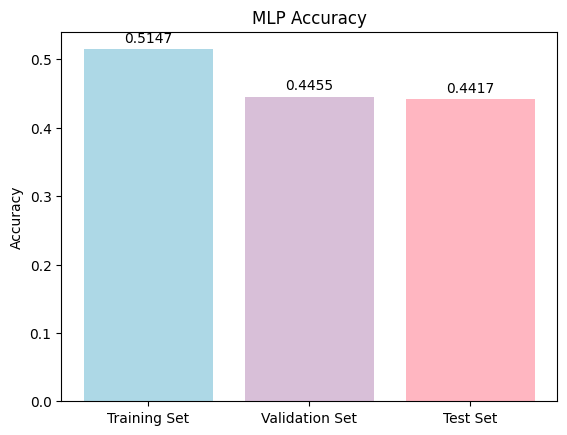

In [15]:
# Evaluate the model's accuracy on the training, validation and testing set
train_loss_mlp, train_accuracy_mlp = model_mlp.evaluate(X_train, y_train, verbose=0)
val_loss_mlp, val_accuracy_mlp = model_mlp.evaluate(X_val, y_val, verbose=0)
test_loss_mlp, test_accuracy_mlp = model_mlp.evaluate(X_test, y_test, verbose=0)

plot_bar_chart(train_accuracy_mlp, val_accuracy_mlp, test_accuracy_mlp, 'MLP Accuracy', 'Accuracy')

>In this specific run of the code, the MLP model achieved the following accuracy rates:

>- Training Accuracy: 55.89%
- Validation Accuracy: 48.23%
- Testing Accuracy: 47.85%

>These accuracy values represent the model's ability to correctly classify data from the respective sets. The lower validation and testing accuracies in comaprison to the training accuracy, suggest that the model may not generalise well to unseen data, possibly indicating that it is overfitting to the training data. The model may benefit from further refinement.

313/313 [==============================] - 1s 2ms/step


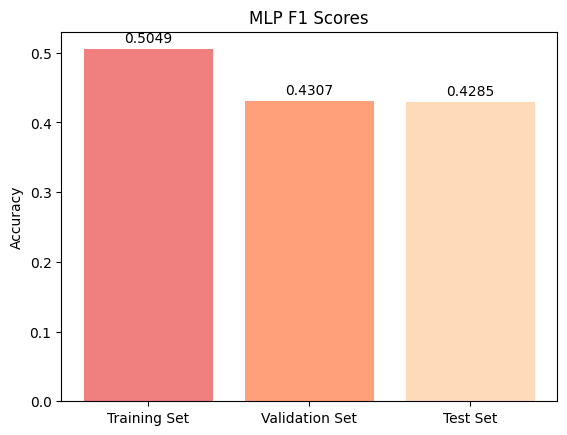

In [16]:
# Evaluate the model's F1 scores for the training, validation and testing set
y_train_pred_mlp = model_mlp.predict(X_train)
train_f1_score_mlp = calculate_f1_score(y_train, np.argmax(y_train_pred_mlp, axis=1))
y_val_pred_mlp = model_mlp.predict(X_val)
val_f1_score_mlp = calculate_f1_score(y_val, np.argmax(y_val_pred_mlp, axis=1))
y_test_pred_mlp = model_mlp.predict(X_test)
test_f1_score_mlp = calculate_f1_score(y_test, np.argmax(y_test_pred_mlp, axis=1))

plot_bar_chart(train_f1_score_mlp, val_f1_score_mlp, test_f1_score_mlp, 'MLP F1 Scores', 'F1', colors=['lightcoral', 'lightsalmon', 'peachpuff'])

> In this specific run of the code, the MLP model achieved the following F1 rates:

> - Training F1 Score: 0.5572
- Validation F1 Score: 0.4788
- Testing F1 Score: 0.4714

>These F1 scores are indicative of the model's ability to balance precision and recall on the respective datasets. It is useful when we have class inbalances. In this dataset, the classes are all evenly balanced, hence, we see a very similar pattern to the accuracy scores with the training set having a much higher F1 score.

In [17]:
def plot_confusion_matrix(y_test, y_pred, display_labels=class_names, cmap=plt.cm.Purples, title="Confusion Matrix"):
  '''Plots a confusion matrix to visualise classification results.'''

  fig, ax = plt.subplots(1, figsize=(10, 10))
  cm = confusion_matrix(y_test, y_pred, normalize='true')

  conf_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  conf_display.plot(cmap=cmap, ax=ax, xticks_rotation=90)

  ax.set_title(title)

1329/1329 [==============================] - 3s 2ms/step


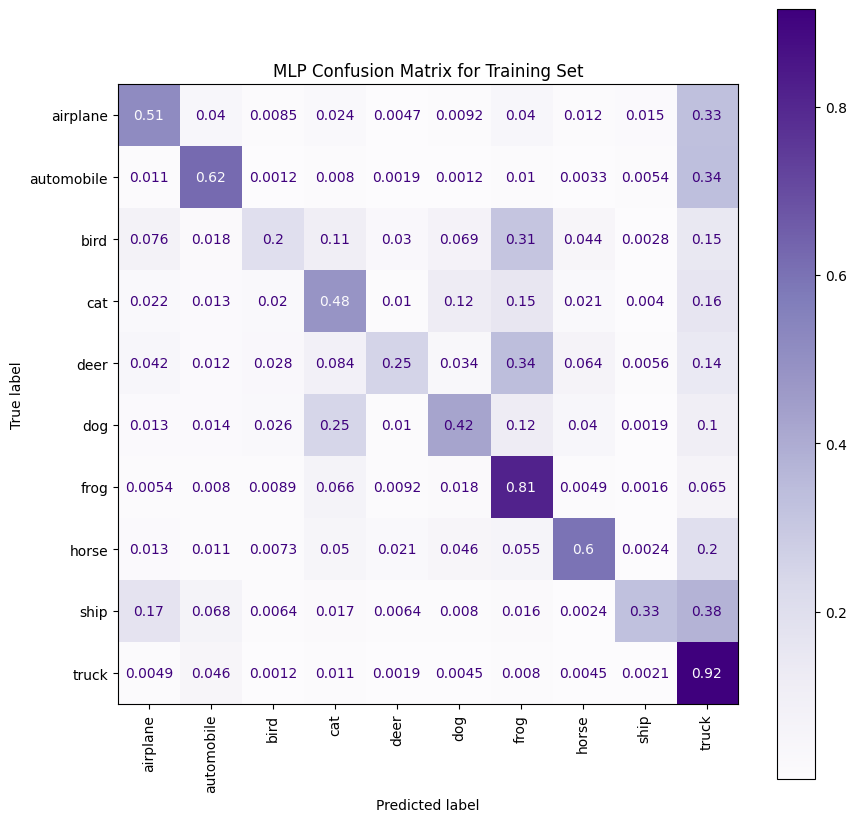

In [18]:
# Plotting the confusion matrix for the training set
mlp_pred_train = np.argmax(model_mlp.predict(X_train),axis=-1)
plot_confusion_matrix(y_train, mlp_pred_train, title="MLP Confusion Matrix for Training Set")
plt.show()

313/313 [==============================] - 1s 2ms/step


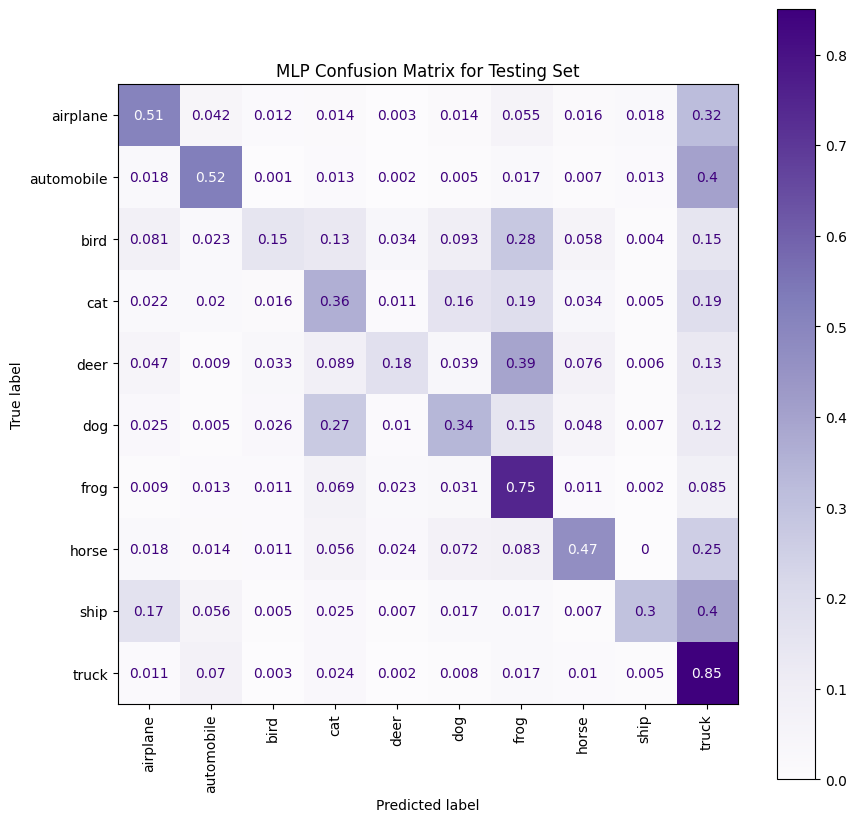

In [19]:
# Plotting the confusion matrix for the testing set
mlp_pred_test = np.argmax(model_mlp.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, mlp_pred_test, title="MLP Confusion Matrix for Testing Set")
plt.show()

>We see a consistent pattern in the results for both the training and testing sets. Notably, certain classes exhibit a higher likelihood of being classified correctly compared to others. We see that horse, ship, truck and automobile have fairly high classification scores. Whereas many of the animal classiciation are far lower, with them being classified as another animal. For example, cats get classified as dogs fairly often and deers as horses. This observation aligns with our intuition, as these animals share certain visual similarities in their appearance.

## Implementing a CNN

In [20]:
def create_cnn_model(kernel_size, num_kernel, activation_function, learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2):
  ''' Creating a CNN model '''
  model = Sequential([
      # Input layer and 1st convolutional layer
      Conv2D(num_kernel, kernel_size, activation=activation_function, input_shape=[32,32,3], kernel_initializer=weight_initializer),
      MaxPool2D(),
      BatchNormalization(),

      # 2nd convolutional layer
      Conv2D(num_kernel*2, kernel_size, activation=activation_function, kernel_initializer=weight_initializer),
      MaxPool2D(),
      BatchNormalization(),

      # Dense Layers and Output
      Flatten(),
      Dense(512, activation=activation_function),
      Dropout(dropout_rate),
      Dense(256, activation=activation_function),
      Dropout(dropout_rate),
      Dense(10, activation='softmax')
  ])

  optimizer = SGD(learning_rate=learning_rate)

  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

> The above code defines the architecture of the CNN model. The CNN model contains two convolutional layers, each followed by a max-pooling and batch normalisation layer. Next, there are dense layers following the exact same architecture as the MLP for consistency and better comparability.

**Architecture**

> *Convolutional Layers*
- The inputted images have dimensions (32, 32, 3).
- The convolutional layers use kernels to input data to detect patterns, edges, and features within the data
- These layers help with feature extraction by convolving the input with multiple filters, each capturing different aspects of the data

> *Max-Pooling Layers*
- Max-pooling is a downsampling technique used in CNNs. It reduces the spatial dimensions of feature maps by selecting the maximum value within a small window
- It helps retain important features while reducing computational complexity and sensitivity to small spatial variations

> *Batch Normalisation*
- Batch normalisation is a regularisation technique
- It normalises the activations within each mini-batch of data during training. It helps stabilise and speed up training.
- Can also regularise the model

>*Next layers*
- Identical to MLP for consistency and better comparisons


### Exploring Hyperparameter Settings for the CNN

> The following code aims to find the best hyperparameter combination for maximising the accuracy using the above model. It has been commented out as training has already been completed. It iterates through different hyperparameter combinations, training a model for each, and outputting the accuracy and loss.

>In this experimentation, I focused on three hyperparameters: `kernel_size`, `num_kernel` and `activation_function`.

>1. Kernel Size
  - I chose to test kernel sizes of (3,3) and (5,5)
  - Smaller kernel sizes, such as (3, 3), capture finer details and are computationally efficient
  - Larger kernel sizes, such as (5, 5), capture more global patterns but may increase computational complexity


>2. Number of Kernels
  - The number of kernels controls the depth/complexity of feature extraction in the convolutional layers. I tested 32 and 64 kernels.
  - Smaller number provide a simpler model with fewer parameters, potentially reducing overfitting, whilelarger numbers create a deeper network with more complex feature extraction capabilities but require more computational resources


>3. Activation Function
  -  The choice of activation functions, `relu` and `tanh` determines the non-linearity in the network
  - `relu` is commonly used due to its simplicity and ability to mitigate vanishing gradient problems during training
  - `tanh` can be useful when dealing with data that may have negative values, as it squashes activations to the range of -1 to 1

Note: the following code was used for hyperparameter exploration:

```# Hyperparameter values to explore
kernel_sizes = [(3, 3), (5, 5)]
num_kernels = [32, 64]
activation_functions = ['relu', 'tanh']

# Lists to store results
results = []

# Iterate through all combinations
for kernel_size in kernel_sizes:
    for num_kernel in num_kernels:
        for activation_function in activation_functions:

          early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
          model = create_cnn_model(kernel_size, num_kernel, activation_function)

          # Train the model with early stopping on the validation set
          history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

          # Evaluate the model on the test set
          test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

          # Print results for each combination of hyperparameters
          print(f"Kernel size: {kernel_size}, Number of kernels: {num_kernel}, Activation function: {activation_function}")
          print("Test loss:", test_loss)
          print("Test accuracy:", test_accuracy)
          print("-" * 40)

          # Store results
          results.append({
              'Kernel Size': kernel_size,
              'Number of Kernels': num_kernel,
              'Activation Function': activation_function,
              'Test Accuracy': test_accuracy
          })

# Print results
for result in results:
    print("Kernel Size:", result['Kernel Size'])
    print("Number of Kernels:", result['Number of Kernels'])
    print("Activation Function:", result['Activation Function'])
    print("Test Accuracy:", result['Test Accuracy'])

```

### Optimal Hyperparameter Combination

>The combination of hyperparameters that resulted in the highest accuracy are:

>(from the MLP model:)
- **Weight Initialization**: `glorot_uniform`
- **Dropout Rate**: `0.2`
- **Learning Rate**: `0.01`
- **Optimizer**: `SGD`

>(from the new training:)
- **Kernel Size**: (5,5)
- **Number of Kernels**: 64
- **ACtivation Function**: `relu`


>**Validation Results**
- **Validation Accuracy**: 0.7156

>**Explanation:**
- **Kernel Size (5,5)**: captures more global patterns in the data, potentially recognising more complex features
- **Number of Kernels (64)**: A higher number of kernels in the convolutional layers results in a deeper network capable of extracting a richer set of features from the images
- **Activation Function (`relu`)**: avoidings the vanishing gradient problem and computationally efficient

>All other hyperparameters were carried over from the training of the MLP for better comparison.

### Checking if Saved Model Exists

In [21]:
model_cnn = load_or_train_model('Molin_Kaylee-CNN', early_stopping, 'CNN')

Model already exists. Training it for 1 more epoch.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
  

### Analysing the CNN Model

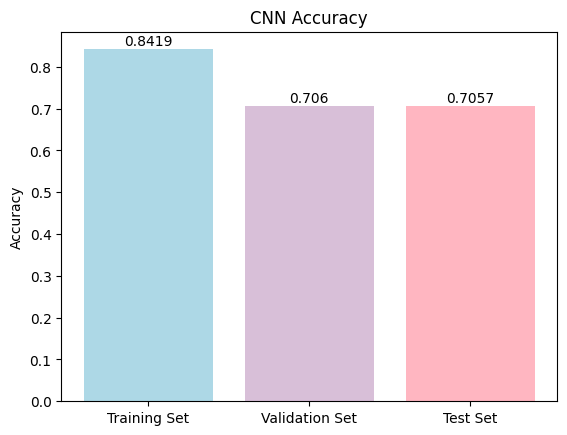

In [22]:
# Evaluate the model on the training, validation and testing set
train_loss_cnn, train_accuracy_cnn = model_cnn.evaluate(X_train, y_train, verbose=0)
val_loss_cnn, val_accuracy_cnn = model_cnn.evaluate(X_val, y_val, verbose=0)
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)

plot_bar_chart(train_accuracy_cnn, val_accuracy_cnn, test_accuracy_cnn, 'CNN Accuracy', 'Accuracy')

> In this specific run of the code, the CNN model achieved the following accuracy rates:

>- Training Accuracy: 87.53%
- Validation Accuracy: 68.91%
- Testing Accuracy: 68.72%

>Similar to the MLP, the lower validation and testing accuracies in comaprison to the training accuracy, suggest that the model may not generalise well to unseen data, possibly indicating that it is overfitting to the training data. The model may benefit from further refinement.

>This accuracy is about 20% higher than the MLP, suggesting that the CNN is a better model for this task.

313/313 [==============================] - 1s 2ms/step


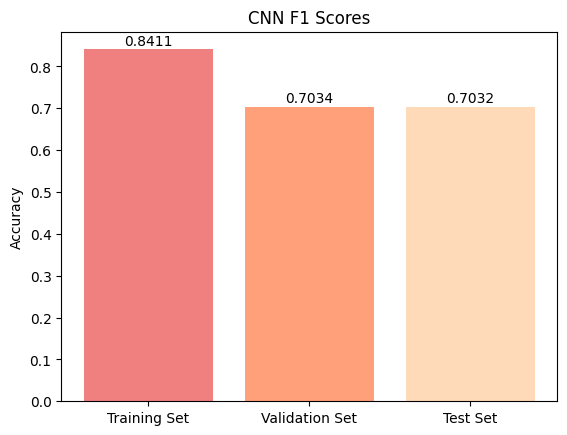

In [23]:
# Evaluate the model's F1 scores for the training, validation and testing set
y_train_pred_cnn = model_cnn.predict(X_train)
train_f1_score_cnn = calculate_f1_score(y_train, np.argmax(y_train_pred_cnn, axis=1))
y_val_pred_cnn = model_cnn.predict(X_val)
val_f1_score_cnn = calculate_f1_score(y_val, np.argmax(y_val_pred_cnn, axis=1))
y_test_pred_cnn = model_cnn.predict(X_test)
test_f1_score_cnn = calculate_f1_score(y_test, np.argmax(y_test_pred_cnn, axis=1))

plot_bar_chart(train_f1_score_cnn, val_f1_score_cnn, test_f1_score_cnn, 'CNN F1 Scores', 'F1', colors=['lightcoral', 'lightsalmon', 'peachpuff'])

>In this specific run of the code, the CNN model achieved the following F1 rates:

>- Training F1 Score: 0.8764
- Validation F1 Score: 0.6886
- Testing F1 Score: 0.6858

>These F1 scores are indicative of the model's ability to balance precision and recall on the respective datasets. It is useful when we have class inbalances. In this dataset, the classes are all evenly balanced, hence, we see a very similar pattern to the accuracy scores with the training set having a much higher F1 score.

1329/1329 [==============================] - 3s 2ms/step


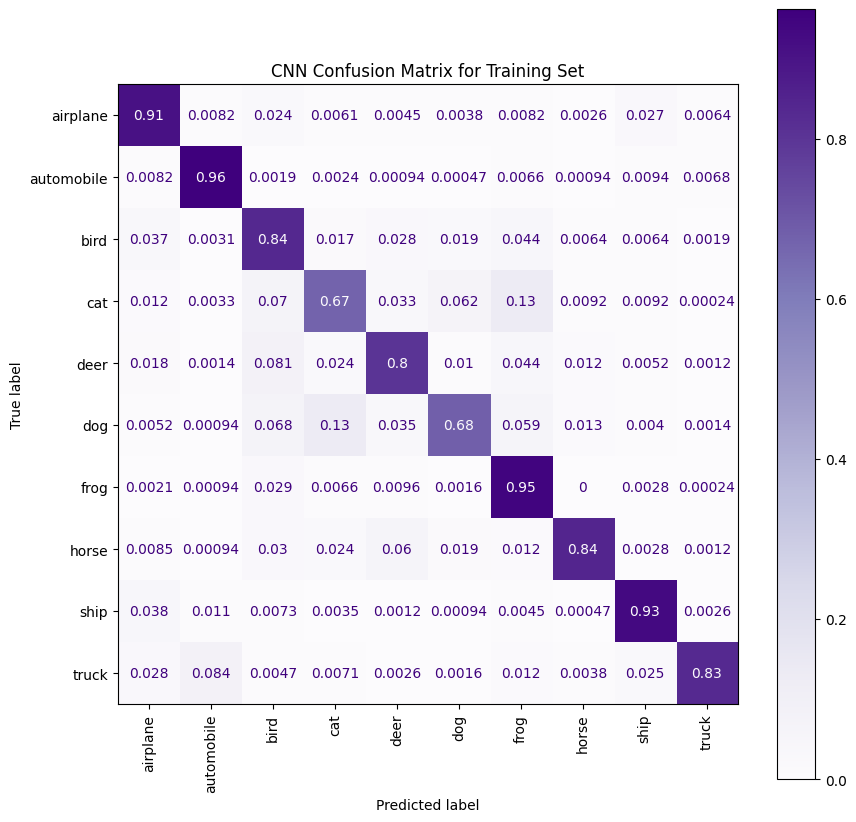

In [24]:
cnn_pred_train = np.argmax(model_cnn.predict(X_train),axis=-1)
plot_confusion_matrix(y_train, cnn_pred_train, title="CNN Confusion Matrix for Training Set")
plt.show()

313/313 [==============================] - 1s 2ms/step


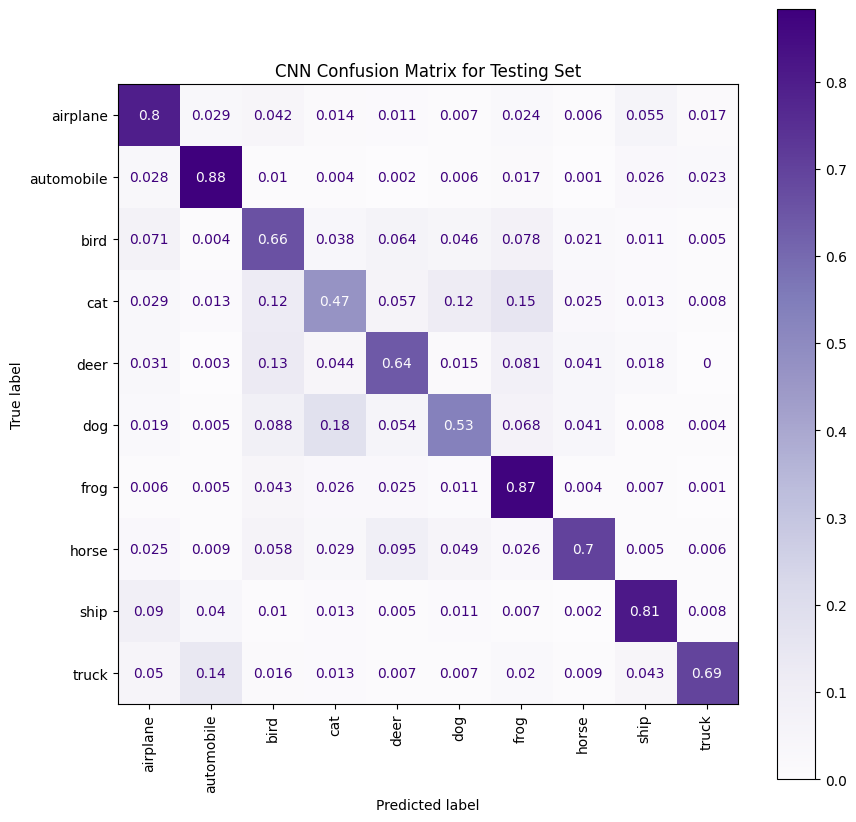

In [25]:
cnn_pred_test = np.argmax(model_cnn.predict(X_test),axis=-1)
plot_confusion_matrix(y_test, cnn_pred_test, title="CNN Confusion Matrix for Testing Set")
plt.show()

>Similar to the MLP, we see a consistent pattern between the training and testing datasets. In contrast to the MLP, we see much higher accuracies on average for image classification. Dogs are still incorrectly being classifid as cats, but most other misclassifications have now been resolved.

## Model Comparison


### Defining the functions to be used for model comparison

In [26]:
def plot_side_by_side(mlp_data, cnn_data, x_titles=['Accuracy', 'F1'] ,rotate=45, title1='MLP', title2='CNN', ylabel='Scores',ylim=1.05):
    '''Plots 2 bar graphs side-by-side comparing the accuracies and F1 scores for each of the models'''
    colors = ['dodgerblue', 'lightskyblue', 'lightblue', 'palegreen', 'yellow']

    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].bar(x_titles, mlp_data, color=colors)
    axes[0].set_title(title1)
    axes[0].set_ylabel(ylabel)
    axes[0].tick_params(axis='x', labelrotation=rotate) # rotate x-tick labels
    axes[0].set_ylim([0, ylim])
    for i, v in enumerate(mlp_data):
        axes[0].text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    # Plot the testing set accuracies
    axes[1].bar(x_titles, cnn_data, color=colors)
    axes[1].set_title(title2)
    axes[1].tick_params(axis='x', labelrotation=rotate) # rotate x-tick labels
    axes[1].set_ylim([0, ylim])
    for i, v in enumerate(cnn_data):
        axes[1].text(i, v + 0.01, str(round(v, 4)), color='black', ha='center')

    # Display the plots
    plt.show()

In [27]:
def calculate_precision_per_class(model, X_test, y_test):
  '''Calculates precision for each class in a classification model.'''
  # Predictions on the test set
  y_pred = model.predict(X_test)
  y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

  # Calculate precision per class
  precision_per_class = precision_score(y_true, np.argmax(y_pred, axis=1), average=None)

  return precision_per_class

In [28]:
def plot_precision_per_class(mlp_precision_per_class, cnn_precision_per_class, class_labels, title='MLP vs CNN Precision per Class', xlabel='Classes', ylabel='Precision', ylim=1.05):
  '''Plots MLP and CNN precision per class side by side'''

  num_classes = len(class_labels)
  x_ticks = np.arange(num_classes)
  width = 0.35  # Width of the bars

  fig, ax = plt.subplots(figsize=(10, 5))

  # Plot MLP precision per class
  ax.bar(x_ticks - width/2, mlp_precision_per_class, width, label='MLP')

  # Plot CNN precision per class
  ax.bar(x_ticks + width/2, cnn_precision_per_class, width, label='CNN')

  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_ylim([0, ylim])
  ax.set_xticks(x_ticks)
  ax.set_xticklabels(class_labels, rotation=0)
  ax.legend(loc='best')

  plt.tight_layout()
  plt.show()

In [29]:
def count_trainable_parameters(model):
  '''Counts the number of trainable parameters in a given model.'''
  return np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])

In [30]:
def display_images(images, true_labels, pred_labels_mlp, pred_labels_cnn, title, colors):
  ''' Displays a grid of images with their predicted labels from MLP and CNN models. '''

  num = 8
  plt.figure(figsize=(12, 6))
  plt.suptitle(title, fontsize=12)
  plt.subplots_adjust(top=0.8, hspace=0.5)

  for i in range(num):
    ax = plt.subplot(2, num//2, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    ax.set_title(f"MLP predicted: {class_names[pred_labels_mlp[i]]} \nCNN predicted: {class_names[pred_labels_cnn[i]]} \nTrue: {class_names[true_labels[i]]}", color=colors[i], fontsize=10)
  plt.show()
  print()

def compare_and_visualise_predictions(X_test, y_test, model_mlp, model_cnn, class_names, num_instances=200):
  ''' Displasy a grid of images with their predicted labels from MLP and CNN models.'''
  predictions_mlp = model_mlp.predict(X_test[:num_instances])
  predictions_cnn = model_cnn.predict(X_test[:num_instances])

  pred_labels_mlp = np.argmax(predictions_mlp, axis=1)
  pred_labels_cnn = np.argmax(predictions_cnn, axis=1)

  y_test = y_test.flatten()

  indices_lists = [
    np.where((pred_labels_mlp == y_test[:num_instances]) & (pred_labels_cnn == y_test[:num_instances]))[0],
    np.where((pred_labels_mlp != y_test[:num_instances]) & (pred_labels_cnn != y_test[:num_instances]))[0],
    np.where((pred_labels_mlp == y_test[:num_instances]) & (pred_labels_cnn != y_test[:num_instances]))[0],
    np.where((pred_labels_mlp != y_test[:num_instances]) & (pred_labels_cnn == y_test[:num_instances]))[0]
  ]

  titles = ["(i) Both Models Correct", "(ii) Both Models Incorrect", "(iii) MLP Correct, CNN Incorrect", "(iv) CNN Correct, MLP Incorrect"]
  colors = [['green'] * num_instances, ['red'] * num_instances, ['black'] * num_instances, ['black'] * num_instances]

  for i, indices in enumerate(indices_lists):
    sample_images = X_test[indices][:num_instances]
    true_labels = y_test[indices][:num_instances]

    display_images(sample_images, true_labels, pred_labels_mlp[indices][:num_instances], pred_labels_cnn[indices][:num_instances], title=titles[i], colors=colors[i])



### Comparing results

**Classification Performance**:

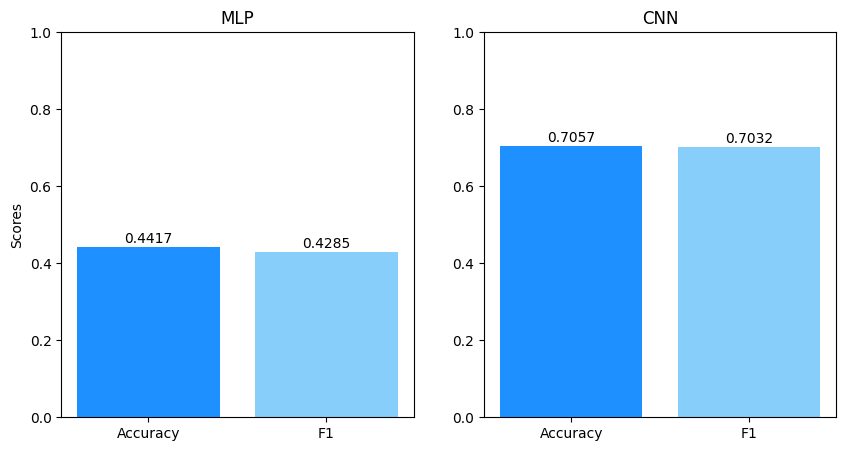

In [31]:
# Accuracy and F1 scores
plot_side_by_side([test_accuracy_mlp, test_f1_score_mlp], [test_accuracy_cnn, test_f1_score_cnn], ylim=1,rotate=0)

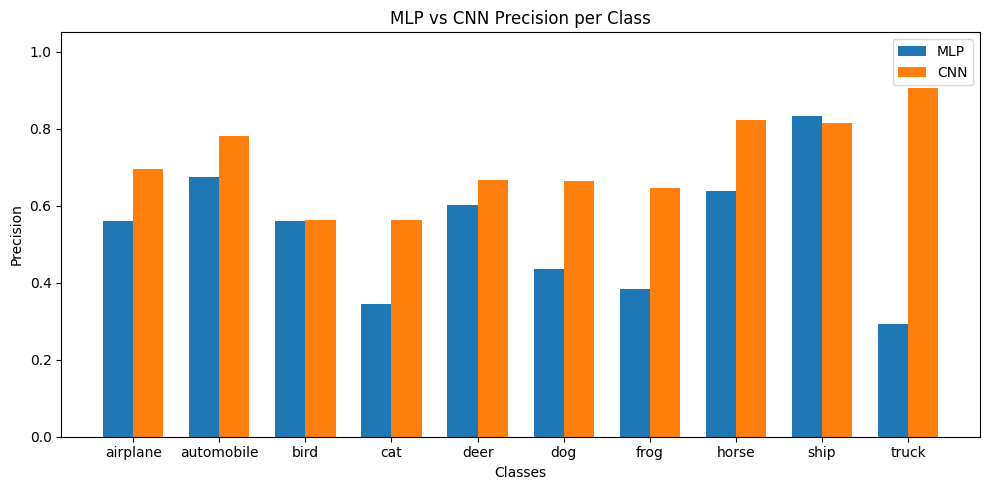

In [32]:
# Precision per class
mlp_report = classification_report(y_test,mlp_pred_test,target_names=class_names, output_dict=True)
mlp_precision_per_class = [mlp_report[class_label]['precision'] for class_label in class_names]

cnn_report = classification_report(y_test,cnn_pred_test,target_names=class_names, output_dict=True)
cnn_precision_per_class = [cnn_report[class_label]['precision'] for class_label in class_names]

plot_precision_per_class(mlp_precision_per_class, cnn_precision_per_class, class_names)


**Classification Performance**

> The above plots offer a valuable comparison between the MLP and CNN models. Notably, there is a significant increase in both accuracy and F1 score, with the CNN model surpassing the MLP by about 0.2. This improvement is anticipated, given that CNNs are made for image classification tasks, allowing them to capture spatial features effectively.

> When lookin at the precision per class, we that the CNN exhibits higher precision values for nearly all classes. Again, this shows that the CNN is superior in this task.

> However, it is important to note that despite the CNNs higher performance,  it achieves an accuracy of only about 0.7. This means that a significant portion of images are still misclassified. Several factors contribute to this, including the relatively low image resolution of 32 x 32 pixels and the variability in angles, zoom levels, and variations within each class. Nevertheless, achieving an accuracy of 0.7 is good, considering the challenges presented by the dataset.



**Model Complexity:**

In [33]:
# Number of trainable parameters
print(f"MLP Trainable Parameters: {count_trainable_parameters(model_mlp)}")
print(f"CNN Trainable Parameters: {count_trainable_parameters(model_cnn)}")


MLP Trainable Parameters: 1707274
CNN Trainable Parameters: 1982986


**Model Complexity**

>As shown in the above print statement, the MLP has 1,707,274 trainable parameters, while the CNN has 1,982,986. This higher number of trainable parameters for the CNN is expected since it uses a similar architecture to the MLP but with a few additional convolutional layers.

>The training time is influenced by the computer's GPU and the number of trainable parameters. When using Google Colab while connected to Unifi, the training time for an additional epoch was approximately 10 seconds for the MLP and 12 seconds for the CNN (please see print statements during model loading for precise timings).

>Both the number of trainable parameters and training times are comparable between the two models. However, considering that the CNN achieved significantly higher accuracy with only a slight increase in model complexity, it proves to be the optimal choice for this classification task.

**Image Classification Examples for Each of the Models:**

7/7 [==============================] - 0s 29ms/step


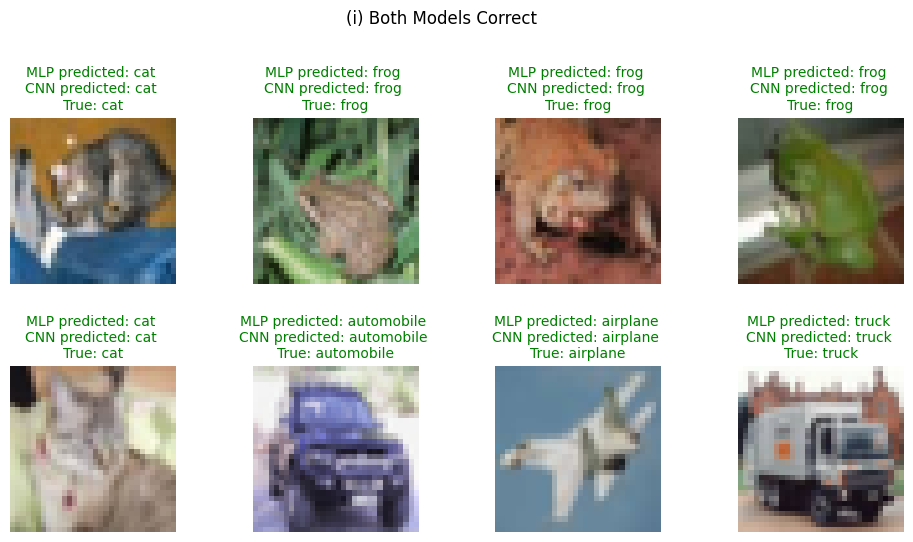

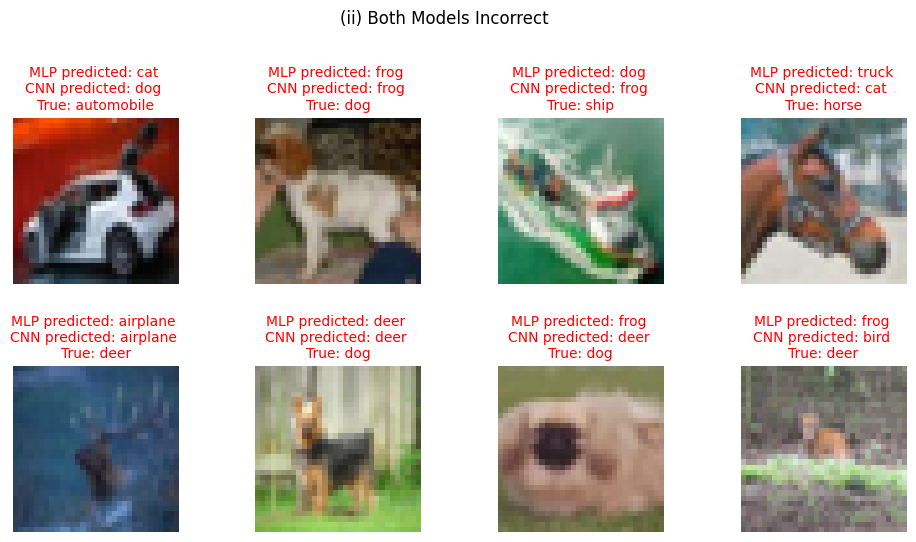

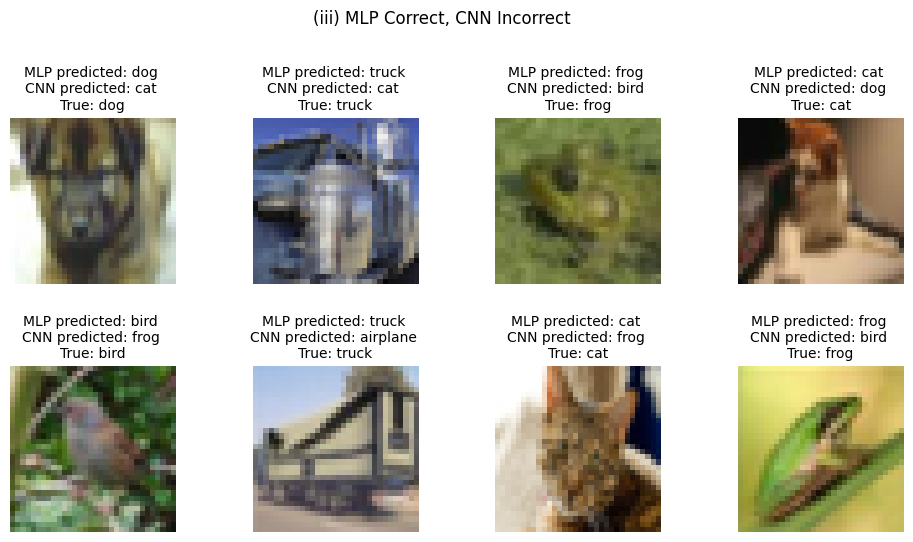

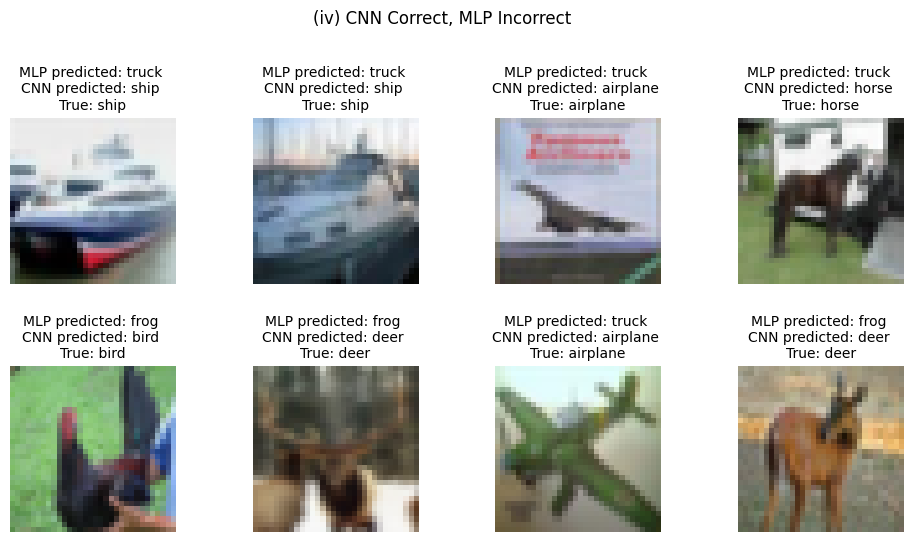

In [34]:
compare_and_visualise_predictions(X_test, y_test, model_mlp, model_cnn, class_names)

>The above plots show examples of where (i) both models made correct classifications, (ii) both models made incorrect classifications, (iii) the MLP correctly classified while the CNN did not, and (iv) the CNN correctly classified while the MLP did not.

>Interestingly, both models consistently made accurate classifications when images displayed clear edges. Conversely, they tended to produce incorrect classifications when images were significantly zoomed in or had low contrast.

>Overall, both models demonstrated the ability to classify images with greater than random accuracy, even when dealing with low-resolution images and challenging content variations. The CNN consistently outperformed the MLP, which was anticipated due to its capacity to capture spatial features and hierarchies in image data. CNN is generallly a suitable choice for image classification tasks, as proved by this assignment.